In [1]:
import re
import polars as pl
pl.Config.set_tbl_rows(None)

polars.config.Config

In [2]:
pattern = re.compile(
    r"\[info\] (?:\w+)\.([^\s:]+)(?::([\w\.\-]+))?\s+thrpt\s+\d+\s+(≈?\s*\S+)(?:\s±\s+([\d\.]+))?\s+(\S+)"
)

def unicode_superscript_to_float(s: str) -> float:
    """
    Converts a string like '10⁻⁶' or '≈ 10⁻⁵' into a float (e.g., 1e-6).
    """
    superscripts = {
        '⁰': '0', '¹': '1', '²': '2', '³': '3',
        '⁴': '4', '⁵': '5', '⁶': '6', '⁷': '7', '⁸': '8', '⁹': '9',
        '⁻': '-', '⁺': '+'
    }
    s = s.replace('≈', '').strip()
    if '10' in s:
        base, power = s.split('10')
        exp = ''.join(superscripts.get(ch, '') for ch in power)
        return float(f"1e{exp}")
    return float(s)

# Regex pattern for extracting rows
def parse_jmh(raw_jmh: str) -> pl.DataFrame:
    rows = []
    for m in pattern.finditer(raw_jmh):
        benchmark = m.group(1)
        metric = m.group(2) or "throughput"
        val_str = m.group(3).strip()
        try:
            value = float(val_str.replace("≈", ""))
        except ValueError:
            value = unicode_superscript_to_float(val_str)
        error = float(m.group(4)) if m.group(4) else None
        unit = m.group(5)
        rows.append((benchmark, metric, value, error, unit))


    # Create Polars DataFrame
    df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])
    return df

In [3]:
raw_jmh_prog = """
[info] BacktrackBenchmark.matchAlternationFailLate                     thrpt   10     126.484 ±    4.582  ops/ms
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate       thrpt   10       0.001 ±    0.001  MB/sec
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate.norm  thrpt   10       0.004 ±    0.001    B/op
[info] BacktrackBenchmark.matchAlternationFailLate:gc.count            thrpt   10         ≈ 0             counts
[info] BacktrackBenchmark.matchAlternationHit                          thrpt   10  205597.701 ± 5626.293  ops/ms
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate            thrpt   10       0.001 ±    0.001  MB/sec
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate.norm       thrpt   10      ≈ 10⁻⁶               B/op
[info] BacktrackBenchmark.matchAlternationHit:gc.count                 thrpt   10         ≈ 0             counts
[info] BacktrackBenchmark.matchBacktrackTrap                           thrpt   10   34317.522 ± 1503.136  ops/ms
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate             thrpt   10       0.001 ±    0.001  MB/sec
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate.norm        thrpt   10      ≈ 10⁻⁵               B/op
[info] BacktrackBenchmark.matchBacktrackTrap:gc.count                  thrpt   10         ≈ 0             counts
[info] BacktrackBenchmark.matchBigClass                                thrpt   10    4101.543 ±  281.476  ops/ms
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate                  thrpt   10   15400.969 ± 1050.835  MB/sec
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate.norm             thrpt   10    3944.000 ±    0.001    B/op
[info] BacktrackBenchmark.matchBigClass:gc.count                       thrpt   10     317.000             counts
[info] BacktrackBenchmark.matchBigClass:gc.time                        thrpt   10     171.000                 ms
[info] BacktrackBenchmark.matchFailLargeClass                          thrpt   10   88196.591 ± 1032.987  ops/ms
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate            thrpt   10       0.001 ±    0.001  MB/sec
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate.norm       thrpt   10      ≈ 10⁻⁵               B/op
[info] BacktrackBenchmark.matchFailLargeClass:gc.count                 thrpt   10         ≈ 0             counts
"""

prog_df = parse_jmh(raw_jmh_prog)
print(prog_df)

shape: (21, 5)
┌──────────────────────────┬────────────────────┬────────────┬──────────┬────────┐
│ benchmark                ┆ metric             ┆ value      ┆ error    ┆ unit   │
│ ---                      ┆ ---                ┆ ---        ┆ ---      ┆ ---    │
│ str                      ┆ str                ┆ f64        ┆ f64      ┆ str    │
╞══════════════════════════╪════════════════════╪════════════╪══════════╪════════╡
│ matchAlternationFailLate ┆ throughput         ┆ 126.484    ┆ 4.582    ┆ ops/ms │
│ matchAlternationFailLate ┆ gc.alloc.rate      ┆ 0.001      ┆ 0.001    ┆ MB/sec │
│ matchAlternationFailLate ┆ gc.alloc.rate.norm ┆ 0.004      ┆ 0.001    ┆ B/op   │
│ matchAlternationFailLate ┆ gc.count           ┆ 0.0        ┆ null     ┆ counts │
│ matchAlternationHit      ┆ throughput         ┆ 205597.701 ┆ 5626.293 ┆ ops/ms │
│ …                        ┆ …                  ┆ …          ┆ …        ┆ …      │
│ matchBigClass            ┆ gc.time            ┆ 171.0      ┆ null     

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_41964/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [4]:
raw_jmh_cps = """
[info] Benchmark                                                        Mode  Cnt       Score       Error   Units
[info] BacktrackBenchmark.matchAlternationFailLate                     thrpt   10     113.044 ±     2.584  ops/ms
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate       thrpt   10       1.725 ±     0.040  MB/sec
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate.norm  thrpt   10      16.005 ±     0.001    B/op
[info] BacktrackBenchmark.matchAlternationFailLate:gc.count            thrpt   10       2.000              counts
[info] BacktrackBenchmark.matchAlternationFailLate:gc.time             thrpt   10       3.000                  ms
[info] BacktrackBenchmark.matchAlternationHit                          thrpt   10  163264.809 ± 10929.579  ops/ms
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate            thrpt   10    2489.246 ±   169.564  MB/sec
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate.norm       thrpt   10      16.000 ±     0.001    B/op
[info] BacktrackBenchmark.matchAlternationHit:gc.count                 thrpt   10     144.000              counts
[info] BacktrackBenchmark.matchAlternationHit:gc.time                  thrpt   10      77.000                  ms
[info] BacktrackBenchmark.matchBacktrackTrap                           thrpt   10   33376.408 ±  2421.052  ops/ms
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate             thrpt   10     509.033 ±    36.999  MB/sec
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate.norm        thrpt   10      16.000 ±     0.001    B/op
[info] BacktrackBenchmark.matchBacktrackTrap:gc.count                  thrpt   10      61.000              counts
[info] BacktrackBenchmark.matchBacktrackTrap:gc.time                   thrpt   10      23.000                  ms
[info] BacktrackBenchmark.matchBigClass                                thrpt   10    4046.940 ±   384.816  ops/ms
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate                  thrpt   10   15271.827 ±  1459.557  MB/sec
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate.norm             thrpt   10    3960.000 ±     0.001    B/op
[info] BacktrackBenchmark.matchBigClass:gc.count                       thrpt   10     317.000              counts
[info] BacktrackBenchmark.matchBigClass:gc.time                        thrpt   10     182.000                  ms
[info] BacktrackBenchmark.matchFailLargeClass                          thrpt   10   63218.455 ± 10133.051  ops/ms
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate            thrpt   10     964.343 ±   154.800  MB/sec
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate.norm       thrpt   10      16.000 ±     0.001    B/op
[info] BacktrackBenchmark.matchFailLargeClass:gc.count                 thrpt   10     116.000              counts
[info] BacktrackBenchmark.matchFailLargeClass:gc.time                  thrpt   10      36.000                  ms
"""

cps_df = parse_jmh(raw_jmh_cps)
print(cps_df)

shape: (25, 5)
┌──────────────────────────┬────────────────────┬───────────┬───────────┬────────┐
│ benchmark                ┆ metric             ┆ value     ┆ error     ┆ unit   │
│ ---                      ┆ ---                ┆ ---       ┆ ---       ┆ ---    │
│ str                      ┆ str                ┆ f64       ┆ f64       ┆ str    │
╞══════════════════════════╪════════════════════╪═══════════╪═══════════╪════════╡
│ matchAlternationFailLate ┆ throughput         ┆ 113.044   ┆ 2.584     ┆ ops/ms │
│ matchAlternationFailLate ┆ gc.alloc.rate      ┆ 1.725     ┆ 0.04      ┆ MB/sec │
│ matchAlternationFailLate ┆ gc.alloc.rate.norm ┆ 16.005    ┆ 0.001     ┆ B/op   │
│ matchAlternationFailLate ┆ gc.count           ┆ 2.0       ┆ null      ┆ counts │
│ matchAlternationFailLate ┆ gc.time            ┆ 3.0       ┆ null      ┆ ms     │
│ …                        ┆ …                  ┆ …         ┆ …         ┆ …      │
│ matchFailLargeClass      ┆ throughput         ┆ 63218.455 ┆ 10133.051 

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_41964/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [5]:
raw_jmh_javaimpl = """
[info] Benchmark                                                        Mode  Cnt      Score     Error   Units
[info] BacktrackBenchmark.matchAlternationFailLate                     thrpt   10     26.803 ±   0.878  ops/ms
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate       thrpt   10    532.539 ±  17.473  MB/sec
[info] BacktrackBenchmark.matchAlternationFailLate:gc.alloc.rate.norm  thrpt   10  20840.021 ±   0.002    B/op
[info] BacktrackBenchmark.matchAlternationFailLate:gc.count            thrpt   10     63.000            counts
[info] BacktrackBenchmark.matchAlternationFailLate:gc.time             thrpt   10     24.000                ms
[info] BacktrackBenchmark.matchAlternationHit                          thrpt   10  20701.254 ± 538.638  ops/ms
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate            thrpt   10   4105.053 ± 106.697  MB/sec
[info] BacktrackBenchmark.matchAlternationHit:gc.alloc.rate.norm       thrpt   10    208.000 ±   0.001    B/op
[info] BacktrackBenchmark.matchAlternationHit:gc.count                 thrpt   10    201.000            counts
[info] BacktrackBenchmark.matchAlternationHit:gc.time                  thrpt   10     90.000                ms
[info] BacktrackBenchmark.matchBacktrackTrap                           thrpt   10   3663.638 ± 172.075  ops/ms
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate             thrpt   10   1536.835 ±  72.455  MB/sec
[info] BacktrackBenchmark.matchBacktrackTrap:gc.alloc.rate.norm        thrpt   10    440.000 ±   0.001    B/op
[info] BacktrackBenchmark.matchBacktrackTrap:gc.count                  thrpt   10    115.000            counts
[info] BacktrackBenchmark.matchBacktrackTrap:gc.time                   thrpt   10     43.000                ms
[info] BacktrackBenchmark.matchBigClass                                thrpt   10   9379.212 ± 190.450  ops/ms
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate                  thrpt   10   1144.686 ±  23.411  MB/sec
[info] BacktrackBenchmark.matchBigClass:gc.alloc.rate.norm             thrpt   10    128.000 ±   0.001    B/op
[info] BacktrackBenchmark.matchBigClass:gc.count                       thrpt   10    137.000            counts
[info] BacktrackBenchmark.matchBigClass:gc.time                        thrpt   10     36.000                ms
[info] BacktrackBenchmark.matchFailLargeClass                          thrpt   10  23999.821 ± 941.262  ops/ms
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate            thrpt   10   2929.000 ± 115.151  MB/sec
[info] BacktrackBenchmark.matchFailLargeClass:gc.alloc.rate.norm       thrpt   10    128.000 ±   0.001    B/op
[info] BacktrackBenchmark.matchFailLargeClass:gc.count                 thrpt   10    154.000            counts
[info] BacktrackBenchmark.matchFailLargeClass:gc.time                  thrpt   10     74.000                ms
"""

javaimpl_df = parse_jmh(raw_jmh_javaimpl)

print(javaimpl_df)

shape: (25, 5)
┌──────────────────────────┬────────────────────┬───────────┬─────────┬────────┐
│ benchmark                ┆ metric             ┆ value     ┆ error   ┆ unit   │
│ ---                      ┆ ---                ┆ ---       ┆ ---     ┆ ---    │
│ str                      ┆ str                ┆ f64       ┆ f64     ┆ str    │
╞══════════════════════════╪════════════════════╪═══════════╪═════════╪════════╡
│ matchAlternationFailLate ┆ throughput         ┆ 26.803    ┆ 0.878   ┆ ops/ms │
│ matchAlternationFailLate ┆ gc.alloc.rate      ┆ 532.539   ┆ 17.473  ┆ MB/sec │
│ matchAlternationFailLate ┆ gc.alloc.rate.norm ┆ 20840.021 ┆ 0.002   ┆ B/op   │
│ matchAlternationFailLate ┆ gc.count           ┆ 63.0      ┆ null    ┆ counts │
│ matchAlternationFailLate ┆ gc.time            ┆ 24.0      ┆ null    ┆ ms     │
│ …                        ┆ …                  ┆ …         ┆ …       ┆ …      │
│ matchFailLargeClass      ┆ throughput         ┆ 23999.821 ┆ 941.262 ┆ ops/ms │
│ matchFailLa

/var/folders/vd/3qxwhj0s52bfzjbgt10xczn00000gn/T/ipykernel_41964/2346540513.py:38: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["benchmark", "metric", "value", "error", "unit"])


In [6]:
dfs = {
    "prog": prog_df,
    "cps": cps_df,
    "javaimpl": javaimpl_df
}

# filter by throughput, concatenate, add source
filtered_dfs = []
for source, df in dfs.items():
    # Filter for throughput metrics
    filtered_df = df.filter(pl.col("metric") == "throughput")
    
    # Add a new column with the source name
    filtered_df = filtered_df.with_columns(pl.lit(source).alias("source"))
    
    # Append the filtered DataFrame to the list
    filtered_dfs.append(filtered_df)

# Concatenate the filtered DataFrames
combined_df = pl.concat(filtered_dfs)

print(combined_df)

shape: (15, 6)
┌──────────────────────────┬────────────┬────────────┬──────────┬────────┬──────────┐
│ benchmark                ┆ metric     ┆ value      ┆ error    ┆ unit   ┆ source   │
│ ---                      ┆ ---        ┆ ---        ┆ ---      ┆ ---    ┆ ---      │
│ str                      ┆ str        ┆ f64        ┆ f64      ┆ str    ┆ str      │
╞══════════════════════════╪════════════╪════════════╪══════════╪════════╪══════════╡
│ matchAlternationFailLate ┆ throughput ┆ 126.484    ┆ 4.582    ┆ ops/ms ┆ prog     │
│ matchAlternationHit      ┆ throughput ┆ 205597.701 ┆ 5626.293 ┆ ops/ms ┆ prog     │
│ matchBacktrackTrap       ┆ throughput ┆ 34317.522  ┆ 1503.136 ┆ ops/ms ┆ prog     │
│ matchBigClass            ┆ throughput ┆ 4101.543   ┆ 281.476  ┆ ops/ms ┆ prog     │
│ matchFailLargeClass      ┆ throughput ┆ 88196.591  ┆ 1032.987 ┆ ops/ms ┆ prog     │
│ …                        ┆ …          ┆ …          ┆ …        ┆ …      ┆ …        │
│ matchAlternationFailLate ┆ throughput

In [7]:
# normalise all values and errors relative to prog
prog_df = combined_df.filter(pl.col("source") == "prog").select(["benchmark", "value", "error"]).rename({"value": "value_prog", "error": "error_prog"})
cps_df = combined_df.filter(pl.col("source") == "cps").select(["benchmark", "value", "error"]).rename({"value": "value_cps", "error": "error_cps"})
javaimpl_df = combined_df.filter(pl.col("source") == "javaimpl").select(["benchmark", "value", "error"]).rename({"value": "value_javaimpl", "error": "error_javaimpl"})
# Join the DataFrames on the benchmark column
normalised_df = prog_df.join(cps_df, on="benchmark", how="inner").join(javaimpl_df, on="benchmark", how="inner")
# Calculate the relative values and errors
normalised_df = normalised_df.with_columns(
    (pl.col("value_cps") / pl.col("value_prog")).alias("value_cps_rel"),
    (pl.col("error_cps") / pl.col("value_prog")).alias("error_cps_rel"),
    (pl.col("value_javaimpl") / pl.col("value_prog")).alias("value_javaimpl_rel"),
    (pl.col("error_javaimpl") / pl.col("value_prog")).alias("error_javaimpl_rel")
)
# Print the final DataFrame
print(normalised_df)


shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ benchmark ┆ value_pro ┆ error_pro ┆ value_cps ┆ … ┆ value_cps ┆ error_cps ┆ value_jav ┆ error_ja │
│ ---       ┆ g         ┆ g         ┆ ---       ┆   ┆ _rel      ┆ _rel      ┆ aimpl_rel ┆ vaimpl_r │
│ str       ┆ ---       ┆ ---       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ el       │
│           ┆ f64       ┆ f64       ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ matchAlte ┆ 126.484   ┆ 4.582     ┆ 113.044   ┆ … ┆ 0.893742  ┆ 0.020429  ┆ 0.211908  ┆ 0.006942 │
│ rnationFa ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ilLate    ┆           ┆           ┆           ┆   ┆           ┆           

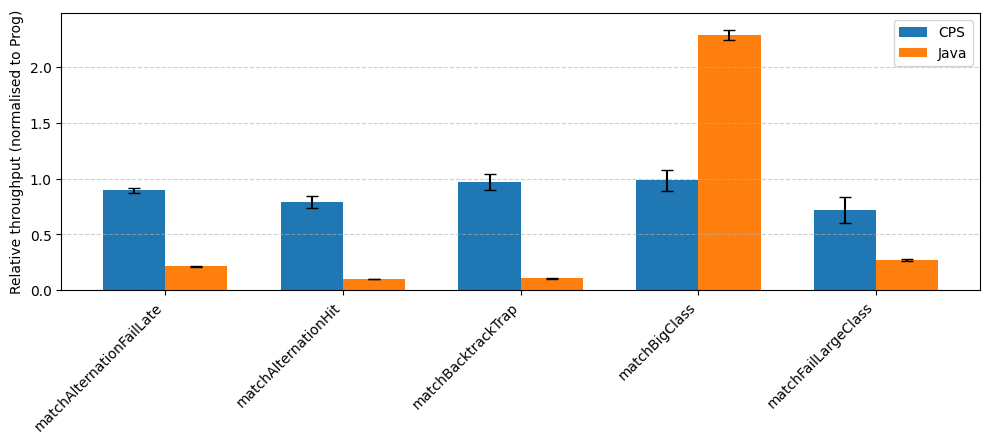

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

# Assume your DataFrame is ready
df = normalised_df  # or whatever your actual DataFrame is

# Plot config
benchmarks = df["benchmark"].to_list()
x = np.arange(len(benchmarks))
width = 0.35

# Extract values
cps = df["value_cps_rel"].to_numpy()
cps_err = df["error_cps_rel"].to_numpy()
java = df["value_javaimpl_rel"].to_numpy()
java_err = df["error_javaimpl_rel"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4.5))  # Wider, flatter aspect
bars1 = ax.bar(x - width/2, cps, width, yerr=cps_err, capsize=4, label="CPS", color="tab:blue")
bars2 = ax.bar(x + width/2, java, width, yerr=java_err, capsize=4, label="Java", color="tab:orange")

# Labels, legend
ax.set_ylabel("Relative throughput (normalised to Prog)")
ax.set_xticks(x)
ax.set_xticklabels(benchmarks, rotation=45, ha="right")
ax.set_ylim(0, max(java.max(), cps.max()) + 0.2)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Tight layout before export
fig.tight_layout()

# Save to TikZ/PGFPlots
tikzplotlib.save("relative_throughput_plot.tex")


In [10]:
# do something similar for gc.alloc.rate.norm
print(combined_df)


shape: (15, 6)
┌──────────────────────────┬────────────┬────────────┬──────────┬────────┬──────────┐
│ benchmark                ┆ metric     ┆ value      ┆ error    ┆ unit   ┆ source   │
│ ---                      ┆ ---        ┆ ---        ┆ ---      ┆ ---    ┆ ---      │
│ str                      ┆ str        ┆ f64        ┆ f64      ┆ str    ┆ str      │
╞══════════════════════════╪════════════╪════════════╪══════════╪════════╪══════════╡
│ matchAlternationFailLate ┆ throughput ┆ 126.484    ┆ 4.582    ┆ ops/ms ┆ prog     │
│ matchAlternationHit      ┆ throughput ┆ 205597.701 ┆ 5626.293 ┆ ops/ms ┆ prog     │
│ matchBacktrackTrap       ┆ throughput ┆ 34317.522  ┆ 1503.136 ┆ ops/ms ┆ prog     │
│ matchBigClass            ┆ throughput ┆ 4101.543   ┆ 281.476  ┆ ops/ms ┆ prog     │
│ matchFailLargeClass      ┆ throughput ┆ 88196.591  ┆ 1032.987 ┆ ops/ms ┆ prog     │
│ …                        ┆ …          ┆ …          ┆ …        ┆ …      ┆ …        │
│ matchAlternationFailLate ┆ throughput

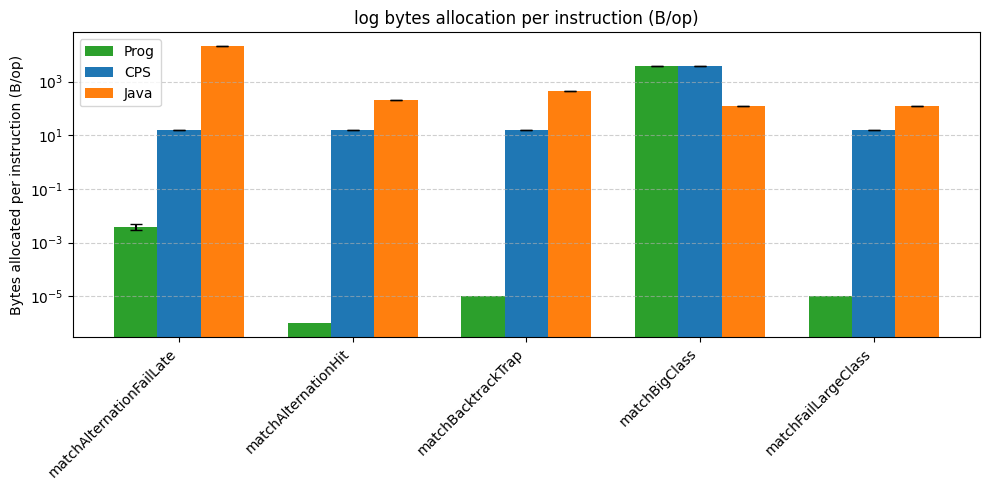

In [15]:
metric = "gc.alloc.rate.norm"
filtered = {}

for name, df in dfs.items():
    filtered[name] = (
        df.filter(pl.col("metric") == metric)
          .select(["benchmark", "value", "error"])
          .rename({"value": f"value_{name}", "error": f"error_{name}"})
    )

# Join all filtered DataFrames on 'benchmark'
merged = filtered["prog"]
for name in ["cps", "javaimpl"]:
    merged = merged.join(filtered[name], on="benchmark")

# Convert to pandas for plotting
benchmarks = merged["benchmark"].to_list()
x = np.arange(len(benchmarks))
width = 0.25

# Values and error bars
vals_prog = merged["value_prog"].to_numpy()
err_prog = merged["error_prog"].to_numpy()
vals_cps = merged["value_cps"].to_numpy()
err_cps = merged["error_cps"].to_numpy()
vals_java = merged["value_javaimpl"].to_numpy()
err_java = merged["error_javaimpl"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width, vals_prog, width, yerr=err_prog, label="Prog", capsize=4, color="tab:green")
ax.bar(x, vals_cps, width, yerr=err_cps, label="CPS", capsize=4, color="tab:blue")
ax.bar(x + width, vals_java, width, yerr=err_java, label="Java", capsize=4, color="tab:orange")

# Labels
ax.set_xticks(x)
ax.set_xticklabels(benchmarks, rotation=45, ha="right")
ax.set_yscale("log")
ax.set_ylabel("Bytes allocated per instruction (B/op)")
ax.set_title("log bytes allocation per instruction (B/op)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
tikzplotlib.save("gc_alloc_rate_norm_plot.tex")
